# P2S: A*, Dynamics, and Sampling

**DUE: Sunday, October 2, 2022**

[Instructions are the same as last time.]

You are *highly recommended* to LaTeX your solutions to this assignment and use the 10pt, 2-column `ieeeconf` template. You can find the template [on Overleaf](https://www.overleaf.com/latex/templates/preparation-of-papers-for-ieee-sponsored-conferences-and-symposia/zfnqfzzzxghk); Overleaf is an online LaTeX editor with a free tier, so feel free to use that service to compose your writeups. It is perhaps the easiest option, particularly if you are not as familiar with LaTeX. While there is no space limit, please try to keep your plots compact so that they do not consume an enormous amount of space; mostly this helps readability (and therefore grading). You are allowed to work in small groups (2 or 3 students), but your solutions and your writeup should be your own.

With these homework assignments, I expect that your solutions will be written as if they are research papers: though the content is not "new", you should be trying to convince me through your writing that you have implemented and understand the algorithms. You should write in full sentences. When appropriate, comment on when the algorithms succeed or fail and where they are more or less effective; include numbers/metrics (quantitative) in addition to discussion (qualitative) whenever possible. Just like in a published paper, you should not include code snippets in your writeup unless it is explicitly asked for or you think it helps you explain your results or answer the question. **I will ask you to submit both the PDF of your writeup *and* a .zip file containing your code (which may be a modified form of this Jupyter notebook) on Blackboard. Unless asked, do not include code in your writeup. You should present your results well enough that I trust your implementation was sufficient.** Though it would be nice if your code were cleaned up and nicely formatted/commented, we will are only likely to run your code to evaluate partial credit or unless we are skeptical for academic integrity reasons.

You are welcome to work in small groups of 2 or 3 students, but please write your solutions independently: I would like your answers to the more conceptual questions to be in your own words, even if you discussed the answers with others.

You will be graded on your included plots and answers to conceptual questions. Your code will not be directly graded or evaluated. You can receive partial credit on pretty much everything, and I try to be a fair as possible: giving you a grade that I think reflects your level of understanding of the material. Note that while I appreciate you submitting plots that you *know* are probably not quite right, it can be hard for me to evaluate partial credit if things are not quite working; in this case, try to include in your response a guess of where you think your solution didn't work. This will help me know when to give you more credit on your responses.

> **Note: you will need to install additional packages in your python venv for this assignment:**
```bash
pip3 install sortedcontainers shapely scikit-image

```


## P2.1 Using A* with Motion Primitives

In the breakout session in class, we showed how A* could be used to plan using motion primitives. Here, I have provided you with some code to get you started in this regard: I have created a small set of motion primitives based on a differential drive vehicle and used those to define a motion-primitive-based search function. In this question, you'll be playing around with this to slowly reproduce a realistic robotic planning problem: goal-directed, receeding-horizon planning in a partial map.

### P2.1.1 A* in a small map


> Note: I've asked for a number of plots here that will look similar to one another. Please label them!

**PLOT** Run the A* planning code without any heuristic

**TASK** Implement `heuristic_fn_cartesian(robot_pose, goal_pose)` below to provide the euclidian distance between the start and the goal.

**PLOT** Run the A* planning code with a Cartesean Distance heuristic and include the resulting trajectory (Note: you will need to modify the code below to provide the heuristic function.) [It is okay if the plan does not reach the goal.]

**PLOT** Run the A* planning code with a Cartesean Distance heuristic multiplied by 1.2. [It is okay if the plan does not reach the goal.]

I have provided you with some functionality that computes `goal_distance_cost_grid`, a grid (computed from the cost grid) where each cell is the distance of traveling along the grid to reach the goal. 

**QUESTION** (2-5 Sentences) How can `goal_distance_cost_grid` be used to implement a heuristic for robot navigation? Explain how this would work and whether or not your heuristic is an admissible one (and why).

**TASK** Implement `heuristic_fn_cost_grid(robot_pose, goal_pose)` using your answer to the question above. (Note: you will need one of these per cost grid. Feel free to have separate definitions for each.)

**CODE** Include your implementation in your writeup.

**PLOT** Run the A* planning code with the `heuristic_fn_cost_grid` heuristic and include the resulting trajectory (Note: you will need to modify the code below to provide the heuristic function.) [It is okay if the plan does not reach the goal.]

**PLOT** Run the A* planning code with the `heuristic_fn_cost_grid` heuristic multiplied by 1.1. [It is okay if the plan does not reach the goal.]

**QUESTION** (2-5 sentences) Which one of these heuristics is better? Why? 

In [ ]:
!pip install sortedcontainers shapely scikit-image

### Provided Code

In [ ]:
import matplotlib
import numpy as np

# Environment Definition & Plotting Functions
LINEWIDTH = 2.0

# Motion Primitive Starter Code
import copy
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import random
import shapely
import shapely.geometry
import shapely.affinity


class Pose(object):
    counter = 0

    def __init__(self, x, y, yaw=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.index = Pose.counter
        Pose.counter += 1

    def __repr__(self):
        return "<Pose x:%4f, y:%4f, yaw:%4f>" % (self.x, self.y, self.yaw)

    @staticmethod
    def cartesian_distance(pose_a, pose_b):
        return math.sqrt(
            math.pow(pose_a.x - pose_b.x, 2) +
            math.pow(pose_a.y - pose_b.y, 2))

    def __mul__(self, oth):
        return oth.__rmul__(self)

    def __rmul__(self, oth):
        """Define transform out = oth*self. This should be the equivalent
        of adding an additional pose 'oth' to the current pose 'self'.
        This means that, for example, if we have a robot in pose 'self' and
        a motion primitive that ends at 'oth' the position of the end of the
        motion primitive in the world frame is oth*self.
        """

        try:
            x = self.x + np.cos(self.yaw) * oth.x - np.sin(
                self.yaw) * oth.y
            y = self.y + np.cos(self.yaw) * oth.y + np.sin(
                self.yaw) * oth.x
            yaw = (self.yaw + oth.yaw) % (2 * np.pi)
            return Pose(x, y, yaw)
        except AttributeError:
            return Pose(oth * self.x, oth * self.y, self.yaw)
        else:
            raise TypeError(('Type {0} cannot rmul a Pose object.').format(
                type(oth).__name__))


class MotionPrimitive():
    def __init__(self, poses, cost):
        self.poses = poses
        self.cost = cost

    def transform(self, pose):
        """Transform the motion primitive by a given pose.
        This is equivalent to 'right multiplying' the pose/transform.
        The resulting primitive should be such that the output poses
        are the input poses applied to the pose.
        """
        new_poses = [p * pose for p in self.poses]
        return MotionPrimitive(poses=new_poses, cost=self.cost)


class RobotState(object):
    """A simple robot that moves using motion primitives.
    This is the base class for robots that use motion primitives to move.
    As such, the 'get_motion_primitives' function must be defined and the
    move class has been updated to include the selected primitive for motion.
    """
    def __init__(self, start_pose, footprint=None):
        self.pose = copy.copy(start_pose)
        self.all_poses = [copy.copy(self.pose)]
        self.net_motion = 0
        self.num_moves = 0
        self.did_collide = False
        self.is_updated = False

        if footprint is None:
            self.footprint = shapely.geometry.Point(0, 0)
        else:
            self.footprint = footprint

    def move(self, primitive, does_collide_fn=None, cost_grid=None):
        # Transform from the robot coordinate frame
        if self.net_motion < 1:
            self.first_transformed_primitive = copy.copy(self)
            self.first_pose = copy.copy(self.pose)
            self.is_updated = True

        new_rstate = copy.copy(self)
        # print("start a new one --------------------------------------")
        # print(self.all_poses)
        # print(new_rstate.all_poses)
        new_rstate.all_poses = [p for p in new_rstate.all_poses]
        # print(new_rstate.all_poses)
        # get a new motion primitive
        transformed_primitive = primitive.transform(new_rstate.pose)

        # Keep track of the first movement for use later
        if self.net_motion < 1:
            new_rstate.first_transformed_primitive = transformed_primitive.poses
            new_rstate.first_pose = transformed_primitive.poses[-1]

        for pose in transformed_primitive.poses:
            if does_collide_fn is not None:
                foot = new_rstate._get_footprint_for_pose(pose)
                new_rstate.did_collide = new_rstate.did_collide or does_collide_fn(foot)
            new_rstate.all_poses.append(copy.copy(pose))

        # Update some terms
        if cost_grid is not None:
            xs = np.array([int(p.x) for p in transformed_primitive.poses])
            ys = np.array([int(p.y) for p in transformed_primitive.poses])
            try:
                new_rstate.net_motion += transformed_primitive.cost * np.mean(cost_grid[xs, ys])
            except:
                new_rstate.net_motion += 10000
            pass
        else:
            new_rstate.net_motion += transformed_primitive.cost
        new_rstate.pose = new_rstate.all_poses[-1]

        return new_rstate

    def move_along_rstate(self, rstate):
        self.all_poses += rstate.first_transformed_primitive
        self.pose = rstate.first_pose

    def get_current_footprint(self):
        return self._get_footprint_for_pose(self.pose)

    def _get_footprint_for_pose(self, pose):
        rfootprint = shapely.affinity.rotate(self.footprint,
                                             pose.yaw,
                                             origin=(0, 0),
                                             use_radians=True)
        lfootprint = shapely.affinity.translate(rfootprint,
                                                xoff=pose.x,
                                                yoff=pose.y)
        return lfootprint


def get_primitive_library(max_theta=np.pi/6, curvature=1.0):
    """Returns the motion primitives available to the robot at the current
    time (can be a function of robot state)."""
    # Create motion primitives
    r = curvature
    return [MotionPrimitive(poses=[Pose(
        x=r * np.sin(d * max_theta / 10),
        y=r * (1 - np.cos(d * max_theta / 10)),
        yaw=d*max_theta/10) for d in range(1, 11)], cost=r * max_theta),
            MotionPrimitive(poses=[Pose(x=r * max_theta, y=0, yaw=0)], cost=r * max_theta),
            MotionPrimitive(poses=[Pose(
        x=r * np.sin(d * max_theta / 10),
        y=r * (np.cos(d * max_theta / 10) - 1),
        yaw=-d*max_theta/10) for d in range(1, 11)], cost=r * max_theta),
           ]

# primitive_library = get_primitive_library()


class World(object):
    """Stores the shapely polygons that define the world (base structure for
    many environments).
    Attributes:
        obstacles: list of shapely polygons
        boudary: shapely polygon which defines the outer obstacle of world
        clutter_element_poses: positions of clutter
        known_space_poly: shapely polygon representing known, free space
        area: area of known space polygon
    """
    def __init__(self, obstacles):
        self.obstacles = obstacles

    def does_poly_collide(self, poly):
        for obstacle in self.obstacles:
            if obstacle.intersects(poly):
                return True

        return False


def plot_world(ax, world, do_show_points=False, alpha=1.0):
    for obstacle in world.obstacles:
        x, y = obstacle.exterior.xy
        if do_show_points:
            ax.plot(x, y, 'ko-', linewidth=LINEWIDTH, alpha=alpha)
        else:
            ax.plot(x, y, 'k', linewidth=LINEWIDTH, alpha=alpha)


def plot_polygon(ax, poly, color=[0.0, 0.0, 1.0], alpha=1.0):
    # Plotting code from: https://sgillies.net/2010/04/06/painting-punctured-polygons-with-matplotlib.html

    if isinstance(poly, shapely.geometry.MultiPolygon):
        [plot_polygon(ax, p, color, alpha) for p in poly]
        return

    def ring_coding(ob):
        # The codes will be all "LINETO" commands, except for "MOVETO"s at the
        # beginning of each subpath
        n = len(ob.coords)
        codes = np.ones(n, dtype=matplotlib.path.Path.code_type) \
            * matplotlib.path.Path.LINETO
        codes[0] = matplotlib.path.Path.MOVETO
        return codes

    def pathify(polygon):
        # Convert coordinates to path vertices. Objects produced by Shapely's
        # analytic methods have the proper coordinate order, no need to sort.
        vertices = np.concatenate([np.asarray(polygon.exterior.coords)] +
                                  [np.asarray(r) for r in polygon.interiors])
        codes = np.concatenate([ring_coding(polygon.exterior)] +
                               [ring_coding(r) for r in polygon.interiors])
        return matplotlib.path.Path(vertices, codes)

    path = pathify(poly)
    patch = matplotlib.patches.PathPatch(path,
                                         facecolor=color,
                                         linewidth=0,
                                         alpha=alpha)
    ax.add_patch(patch)


def plot_robot_state(ax, robot_state, do_plot_poly=False, alpha=1.0):
    xs = [pose.x for pose in robot_state.all_poses]
    ys = [pose.y for pose in robot_state.all_poses]
    plt.plot(xs, ys, alpha=alpha)
    if do_plot_poly:
        plot_polygon(ax, robot_state.get_current_footprint(), alpha=alpha)


### Code 1

In [ ]:
# Starter Code: Define the library of primitives
# from p2code import MotionPrimitive, Pose
# from content/p2core.py import MotionPrimitive, Pose
import numpy as np
# import 

def get_primitive(vr, vl, width=0.1, dt=0.1, num_steps=3):
    pos_x = 0
    pos_y = 0
    theta = 0
    
    states = []

    try:
        R = width / 2 * (vl + vr) / (vr - vl)
    except:
        R = 10000
    omega = (vr - vl) / width
        
    domega = omega * dt

    for ii in range(num_steps):
        if np.abs(vr - vl) < 0.0001:
            # Robot moves in a straight line
            pos_x += vr * dt * np.cos(theta)
            pos_y += vr * dt * np.sin(theta)
            states.append([pos_x, pos_y, theta])
            continue
        
        ICCx = pos_x - R * np.sin(theta)
        ICCy = pos_y + R * np.cos(theta)
        
        updated_state = np.array([
            [np.cos(domega), -np.sin(domega), 0],
            [np.sin(domega), np.cos(domega), 0],
            [0, 0, 1]
        ]) @ np.array([
                [pos_x - ICCx],
                [pos_y - ICCy],
                [theta]
        ]) + np.array([
                [ICCx],
                [ICCy],
                [domega]
        ])

        pos_x = updated_state[0, 0]
        pos_y = updated_state[1, 0]
        theta = updated_state[2, 0]
        
        states.append([pos_x, pos_y, theta])
        
    cost = (np.abs(vr + vl)/2 + np.abs(vr - vl)/2) * dt * num_steps
    poses = [Pose(x, y, th) for (x, y, th) in states]
    return MotionPrimitive(poses=poses, cost=cost)


p1 = get_primitive(vr=1, vl=1, width=2, dt=0.5, num_steps=8)
p2 = get_primitive(vr=0.5, vl=0.75, width=2, dt=0.5, num_steps=6)
p3 = get_primitive(vr=0.75, vl=0.5, width=2, dt=0.5, num_steps=6)
p4 = get_primitive(vr=0, vl=0.5, width=2, dt=0.5, num_steps=6)
p5 = get_primitive(vr=0.5, vl=0, width=2, dt=0.5, num_steps=6)

primitive_library = [p1, p2, p3, p4, p5]

In [ ]:
# Starter Code: A* implementation with primitives

# from p2code import RobotState, plot_robot_state
import copy

def astar_search(robot, goal_pose, cost_grid, primitives, heuristic_fn=None, num_steps=1000):
    final_rstate = None
    start_rstate = RobotState(Pose(robot.pose.x, robot.pose.y, robot.pose.yaw))
    if heuristic_fn is None:
        rstates = SortedList([start_rstate], 
                key=lambda rs: rs.net_motion)
    else:
        rstates = SortedList([start_rstate], 
                     key=lambda rs: rs.net_motion + heuristic_fn(rs.pose, goal_pose))
        # print(rstates)

    # Run search
    for counter in range(num_steps):
        # print(counter)
        # Get the one closest to the goal and remove
        # (SortedList provides this functionality)
        rstate_to_expand = rstates.pop(0)

        # If the goal is reached, we're done.
        if Pose.cartesian_distance(rstate_to_expand.pose, goal_pose) < 2:
            print("Goal found")
            print(f"Num steps: {counter}")
            return rstate_to_expand, rstates
    
        # Get expansions
        expansions = [rstate_to_expand.move(primitive, cost_grid=cost_grid) 
                      for primitive in primitives]
        rstates += expansions # append all the elements in the expansions list
        
    # Return the best of the remaining states
    final_rstate = rstates.pop(0)
    return final_rstate, rstates


In [13]:
import skimage.graph

def heuristic_fn_cartesian(robot_pose, goal_pose):
    # print(goal_pose)
    factor = 1.2
    return factor*np.sqrt(np.square(robot_pose.x-goal_pose.x) + np.square(robot_pose.y-goal_pose.y))

def heuristic_fn_cost_grid(robot_pose, goal_pose):
    # print("Step 1")
    mcp = skimage.graph.MCP_Geometric(cost_grid)
    # print("Step 2")
    goal_dis_cost_grid = mcp.find_costs(starts=[[goal_pose.x, goal_pose.y]])[0]
    # print("Step 3")
    return 1.3*goal_dis_cost_grid[int(robot_pose.x), int(robot_pose.y)]

### Collapse

In [ ]:
# Plotting and results code
# from p2code import RobotState, plot_robot_state
import skimage.graph
from sortedcontainers import SortedList
import matplotlib.pyplot as plt

Goal found
Num steps: 356


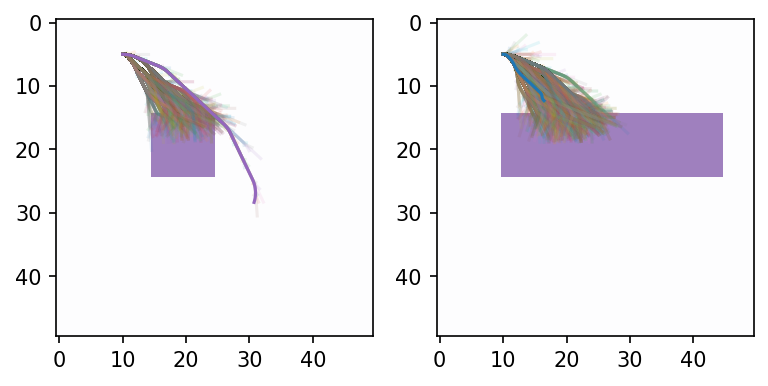

In [ ]:
goal_pose = Pose(x=30, y=30, yaw=0)

# Plot the map and start state
plt.figure(dpi=150)
ax = plt.gca()


cost_grid = np.ones([50, 50])
cost_grid[15:25, 15:25] = 1000


start_pose = Pose(10, 5, 0)
robot = RobotState(start_pose)
# no heuristic function
# final_rstate, rstates = astar_search(
#     robot, goal_pose, cost_grid, primitive_library, 
#     heuristic_fn=None, num_steps=1000)
final_rstate, rstates = astar_search(
    robot, goal_pose, cost_grid, primitive_library, 
    heuristic_fn=heuristic_fn_cartesian, num_steps=1000)

ax = plt.subplot(121)
ax.imshow(cost_grid.T, alpha=0.5, cmap='Purples')
ax.set_aspect('equal', adjustable='box')
for rstate in rstates:
    plot_robot_state(ax, rstate, False, alpha=0.1)
if final_rstate is not None:
    plot_robot_state(ax, final_rstate, False, alpha=1.0)
    
    
cost_grid = np.ones([50, 50])
cost_grid[10:45, 15:25] = 1000
start_pose = Pose(10, 5, 0)
robot = RobotState(start_pose)
final_rstate, rstates = astar_search(
    robot, goal_pose, cost_grid, primitive_library, 
    heuristic_fn=heuristic_fn_cartesian, num_steps=1000)

ax = plt.subplot(122)
ax.imshow(cost_grid.T, alpha=0.5, cmap='Purples')
ax.set_aspect('equal', adjustable='box')
for rstate in rstates:
    plot_robot_state(ax, rstate, False, alpha=0.1)
if final_rstate is not None:
    plot_robot_state(ax, final_rstate, False, alpha=1.0)

### P2.1.2 Receeding Horizon Planning

Unfortunately, planning this way all the way to the goal doesn't always scale very well: it may be impractical to plan all the way to a faraway goal using A*. Instead, we'll implement something called "receeding horizon" planning: we will run A* for some number of steps and if we don't reach the goal, we'll just use the partial trajectory that makes the most progress towards the goal (according to the A* search criteria: path length + the search heuristic). Once a trajectory is picked, the robot moves along it (by one motion primitive) and then replans.

**PLOT** Run the receeding horizon code below. Redefine your heuristic function `heuristic_fn_cost_grid` (for the cost grid below) and run the receeding horizon code. The robot should reach the goal. Include the plot in the resulting code.

**QUESTION** (3-5 sentences) You are asked to use `heuristic_fn_cost_grid` for this question. Why might the `heuristic_fn_cartesian` not work? Give an example of a scenario when the robot might not reach the goal.

**TASK** Below the receeding-horizon code, I have included another cost grid for a *much* larger map. Switch over the code below to plan in this grid instead. Run the resulting code; you should observe that the robot crosses the building and reaches the faraway goal.

**PLOT** Include the plot of the larger map receeding horizon planning code.

Goal found
Num steps: 3
Goal found
Num steps: 0


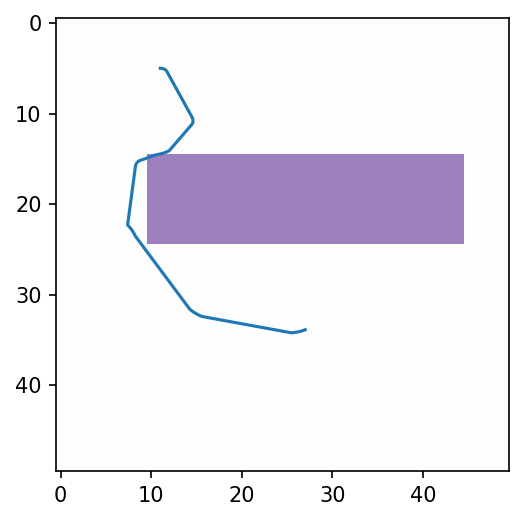

In [17]:
# Receeding Horizon

start_pose = Pose(11, 5, 0)
robot = RobotState(start_pose)
goal_pose = Pose(x=30, y=30, yaw=0)

cost_grid = np.ones([50, 50])
cost_grid[10:45, 15:25] = 1000
# TODO: don't forget to re-define your search heurstic if you need!

new_state = copy.copy(robot)
list_rstates = []
while True:
    final_rstate, rstates = astar_search(
        new_state, goal_pose, cost_grid, primitive_library, 
        heuristic_fn=heuristic_fn_cost_grid, num_steps=5)  
    
    # list_rstates += rstates
    new_state = copy.copy(final_rstate)

    try:
        robot.move_along_rstate(new_state)
    except AttributeError:
        break
    
# Plot the map and start state
plt.figure(dpi=150)
ax = plt.gca()
plot_robot_state(ax, robot)
ax.imshow(cost_grid.T, alpha=0.5, cmap='Purples')
ax.set_aspect('equal', adjustable='box')

# Now we plot the results
# for rstate in list_rstates:
# plot_robot_state(ax, rstate, False, alpha=0.1)
# if new_state is not None:
#     plot_robot_state(ax, new_state, False, alpha=1.0)


### Collapse

Goal found
Num steps: 1
Goal found
Num steps: 0


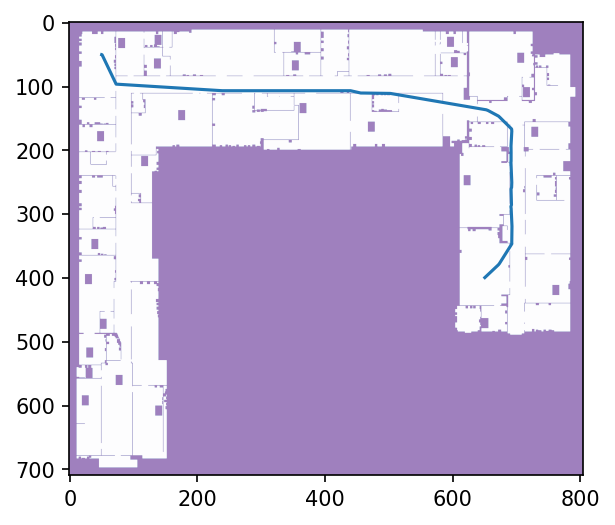

In [ ]:
## NEXT STEP: Here's a bigger grid; re-rerun the code above using 
#  this grid, start and goal.

import pickle
start_pose = Pose(50, 50, 0)
robot = RobotState(start_pose)
goal_pose = Pose(x=650, y=400, yaw=0)
map_data = pickle.load(open("/content/1-0_1030_data.pickle", "rb"))
# print(map_data)
cost_grid = 1000*map_data['occ_grid'] + 1

new_state = copy.copy(robot)
list_rstates = []
while True:
    final_rstate, rstates = astar_search(
        new_state, goal_pose, cost_grid, primitive_library, 
        heuristic_fn=heuristic_fn_cost_grid, num_steps=50)     
    
    list_rstates += rstates
    new_state = copy.copy(final_rstate)
    print(int(new_state.pose.x), int(new_state.pose.y)
    try:
        robot.move_along_rstate(new_state)
    except AttributeError:
        break
    
# Plot the map and start state
plt.figure(dpi=150)
ax = plt.gca()
plot_robot_state(ax, robot)
ax.imshow(cost_grid.T, alpha=0.5, cmap='Purples')
ax.set_aspect('equal', adjustable='box')

# Now we plot the results
# for rstate in list_rstates:
#     plot_robot_state(ax, rstate, False, alpha=0.1)
# if new_state is not None:
#     plot_robot_state(ax, new_state, False, alpha=1.0)

### P2.1.3 Planning in a Partial Map

Finally, what happens if the robot is not given the entire map in advance? Here, you'll use your receeding horizon planning code to understand just that. Here are some guides:


First, start your cost grid to have no information, but keep around a "full cost grid" from which observations will be generated.
```python
# Start with a map containing no information
cost_grid = np.ones_like(map_data['occ_grid'])
full_cost_grid = 1000*map_data['occ_grid'] + 1
```

During the planning loop, before each time you plan, you should update the map using an "observation" of local space. For simplicity, we can 
```python
# Before you plan, update the cost_grid (and your heuristic)
rx = int(robot.pose.x)
ry = int(robot.pose.y)
w = 15
cost_grid[rx-w:rx+w, ry-w:ry+w] = full_cost_grid[rx-w:rx+w, ry-w:ry+w]
mcp = skimage.graph.MCP_Geometric(cost_grid)
goal_distance_cost_grid = mcp.find_costs(starts=[[goal_pose.x, goal_pose.y]])[0]
```

**TASK** Extend the receeding horizon code using the above code snippets to plan in a partial map. Upon running it, you should notice that the robot does not take the shortest path to the goal, since it does not know where all the walls/obstacles are in advance.

**CODE** Include your finished partial map planning snippet in your writeup.

**PLOT** Use this plotting code to show both the full and partial map and include the resulting plot in your writeup:

```python
# Plot the map and start state
plt.figure(dpi=150)
ax = plt.gca()
plot_robot_state(ax, robot)
ax.imshow(full_cost_grid.T, alpha=1.0, cmap='Purples')
ax.imshow(cost_grid.T, alpha=0.7, cmap='Purples')
ax.set_aspect('equal', adjustable='box')
```

New position of robot:  250 50
New position of robot:  403 146
New position of robot:  550 283
Goal found
Num steps: 49
New position of robot:  651 400


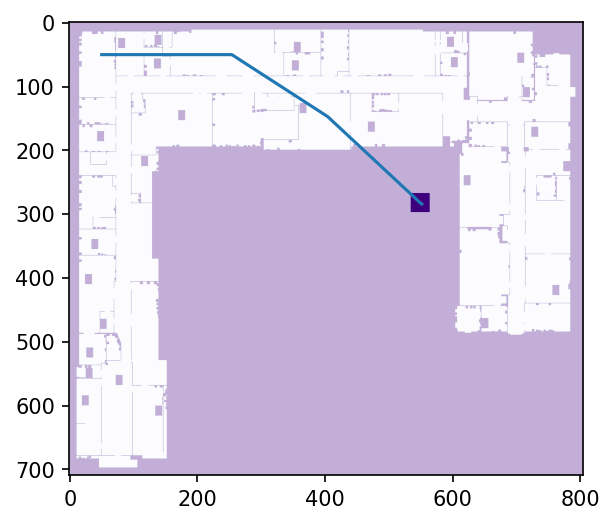

In [18]:
# Receeding Horizon
import pickle
start_pose = Pose(50, 50, 0)
robot = RobotState(start_pose)
goal_pose = Pose(x=650, y=400, yaw=0)
map_data = pickle.load(open("/content/1-0_1030_data.pickle", "rb"))
cost_grid = np.ones_like(map_data['occ_grid'])
full_cost_grid = 1000*map_data['occ_grid'] + 1

new_state = copy.copy(robot)
while True:
    rx = int(new_state.pose.x)
    ry = int(new_state.pose.y)
    w = 15
    cost_grid[rx-w:rx+w, ry-w:ry+w] = full_cost_grid[rx-w:rx+w, ry-w:ry+w]
    final_rstate, rstates = astar_search(
        new_state, goal_pose, cost_grid, primitive_library, 
        heuristic_fn=heuristic_fn_cost_grid, num_steps=50)
     
    # list_rstates += rstates
    new_state = copy.copy(final_rstate)
    print("New position of robot: ", int(new_state.pose.x), int(new_state.pose.y))
    try:
        robot.move_along_rstate(new_state)
    except AttributeError:
        break
    if Pose.cartesian_distance(new_state.pose, goal_pose) < 2:
      break
    
# Plot the map and start state
# plt.figure(dpi=150)
# ax = plt.gca()
# plot_robot_state(ax, robot)
# ax.imshow(cost_grid.T, alpha=0.5, cmap='Purples')
# ax.set_aspect('equal', adjustable='box')

# # Now we plot the results
# for rstate in rstates:
#     plot_robot_state(ax, rstate, False, alpha=0.1)
# if new_state is not None:
#     plot_robot_state(ax, new_state, False, alpha=1.0)

# Plot the map and start state
plt.figure(dpi=150)
ax = plt.gca()
plot_robot_state(ax, robot)
ax.imshow(full_cost_grid.T, alpha=1.0, cmap='Purples')
ax.imshow(cost_grid.T, alpha=0.7, cmap='Purples')
ax.set_aspect('equal', adjustable='box')

## P2.2: Monte Carlo Sampling

Next, we'll transition to thinking about *sampling-based planning*. A prerequisite to that is understanding how sampling can be used to approximately solve problems of interest to us that improve as we continue to sample. This problem is a prerequisite for the next two.

### P2.2.1: Computing Area with MC Sampling [8 points]

In the code below I have provided you with some simple functions to make two different sets of obstacles (and plot them): (1) in which there is only a single rectangular obstacle, and (2) in which there are multiple obstacles. You may use the `shapely` package to check whether or not an obstacle contains a point; here's an example:

```python
from shapely.geometry import Point
point = [5.0, 2.0]
is_inside_obstacle = obstacle.contains(Point(point[0], point[1]))
```

**TASK** Complete the starter code below to approximately compute the area contained within the two environments.

**PLOTS** Include a two plots (one for each environment), showing the points that were inside and outside the different obstacles (after 2500 samples).

**RESULTS/QUESTION** (2-3 sentences) Compute the area for both environments after 100, 1000, 10000, and 100000 samples and include them in your writeup. For the square environment, how does the accuracy of the measurement (compared to the true value) compare as a function of the number of samples?


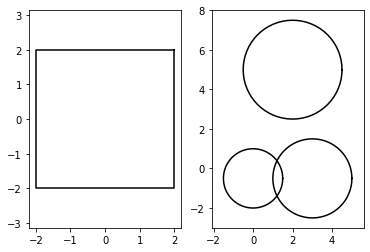

In [ ]:
# Starter code for P2.2.1
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point

def plot_env(obstacles):
    for poly in obstacles:
        plt.plot(*poly.exterior.xy, 'k')

    plt.gca().axis('equal')

env_square = [Point(0, 0).buffer(2.0, cap_style=3)]
env_multi = [
    Point(0, -0.5).buffer(1.5),
    Point(3, -0.5).buffer(2.0),
    Point(2, 5).buffer(2.5),
]

region_x = [-5, 5]
region_y = [-5, 5]

plt.figure()
plt.subplot(121)
plot_env(env_square)
plt.subplot(122)
plot_env(env_multi)

None

In [ ]:
# Sample points and determine which of them fall inside the circle.
import random

def sample_points_in_region(region_x, region_y, obstacles, num_iterations):

    points_inside = []
    points_outside = []
    
    for _ in range(num_iterations):
        is_inside_obstacle = False
        point_x = random.uniform(region_x[0], region_x[1])
        point_y = random.uniform(region_y[0], region_y[1])
        # print(point_x, point_y)
        # print(obstacles)
        for obs in obstacles:
          inside = obs.contains(Point(point_x, point_y))
          # print(inside)
          is_inside_obstacle = is_inside_obstacle or inside 
        if is_inside_obstacle:
            points_inside.append([point_x, point_y])
        else:
            points_outside.append([point_x, point_y])
        # Randomly generate a point and check for inclusion
        # raise NotImplementedError()
            
    return points_inside, points_outside

Num points inside the square: 6
Num points outside: 94
Num points total: 100
The area: 13.5
Num points inside the envi: 14
Num points outside: 86
Num points total: 100
The area: 31.500000000000004


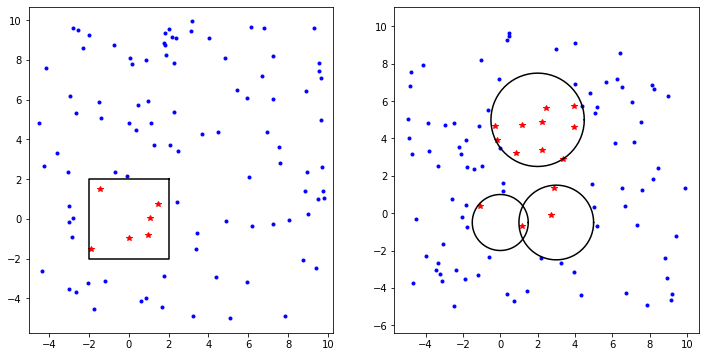

In [ ]:
# Plotting starter code
point_inside, point_outside = sample_points_in_region([-5, 10], [-5, 10], env_square, 100) #2000)) 
plt.figure(figsize=(12, 6))
plt.subplot(121)
# print(point_inside)
pin = np.array(point_inside)
plt.plot(pin[:, 0], pin[:, 1], 'r*')
pout = np.array(point_outside)
plt.plot(pout[:, 0], pout[:, 1], 'b.')
plot_env(env_square)

print(f"Num points inside the square: {len(point_inside)}")
print(f"Num points outside: {len(point_outside)}")
print(f"Num points total: {len(point_inside) + len(point_outside)}")
print(f"The area: {len(point_inside)/(len(point_inside) + len(point_outside))*225}")

point_inside, point_outside = sample_points_in_region([-5, 10], [-5, 10], env_multi, 100) #2000)) 
plt.subplot(122)
pin = np.array(point_inside)
plt.plot(pin[:, 0], pin[:, 1], 'r*')
pout = np.array(point_outside)
plt.plot(pout[:, 0], pout[:, 1], 'b.')
plot_env(env_multi)

# Print the number inside/outside
print(f"Num points inside the envi: {len(point_inside)}")
print(f"Num points outside: {len(point_outside)}")
print(f"Num points total: {len(point_inside) + len(point_outside)}")
print(f"The area: {len(point_inside)/(len(point_inside) + len(point_outside))*225}")

## P2.2.2: More MC Sampling [4 points]

Now we'll use a sampling approach to compute something that isn't merely area, and can be much more difficult to compute exactly. Now answer the following question: *What is the likelihood that a random unit-length line (of random orientation) contained within `x=[-1, 1]` and `y=[-1, 1]` does not intersect a box centered at the origin with side length 1?*

There are a number of things to consider in this question:
- How do we generate a random unit line? There are a number of approaches, though the one I might recommend is to (1) pick a random point within in `x=[-1, 1]` and `y=[-1, 1]`, (2) connect it to another point 1 unit away at along a random direction and then (3) throw it away (and repeat) if it does not. I have provided you with a function `get_random_line` that does this.
- How do we decide if the line intersects with the box? For this you can use Shapely again. Here is an example of checking whether a line intersects a box:

```python
from shapely.geometry import LineString
line = LineString([point_a, point_b])
does_intersect = line.intersects(obstacle)
```

**TASK** Complete the starter `does_line_collides` code below and use it (with a sampling approach) to answer the question above.

**PLOT** Use your code to generate 100 random lines within the specified region that avoid the side-length-1 square at the center. Your plotting code will look something like this:

```python
for line in accepted_lines[:100]:
    l = np.array(line)
    plt.plot(l[:, 0], l[:, 1])
    if does_line_collide(line, env_center_square):
        plt.plot(l[:, 0], l[:, 1], 'r')
```

**RESULT** Include in your writeup the answer to the question above: *What is the likelihood that a random unit-length line (of random orientation) contained within `x=[-1, 1]` and `y=[-1, 1]` does not intersect a box centered at the origin with side length 1?* [Try using >=10000 iterations] To answer this question, generate a *ton* of random lines and compute what percentage of them do not intersect with the box.


In [ ]:
# Starter code for line intersection
from shapely.geometry import LineString

env_center_square = [Point(0, 0).buffer(0.5, cap_style=3)]

def get_random_line(region_x, region_y):
    px = random.uniform(region_x[0], region_x[1])
    py = random.uniform(region_y[0], region_y[1])
    point_a = [px, py]

    theta = random.uniform(0, 2 * np.pi)
    point_b = [px + np.cos(theta), py + np.sin(theta)]
    if point_b[0] < region_x[0] or point_b[0] > region_x[1]:
        return get_random_line(region_x, region_y)
    if point_b[1] < region_y[0] or point_b[1] > region_y[1]:
        return get_random_line(region_x, region_y)
    
    return [point_a, point_b]

def does_line_collide(line, obstacles):
    # print(line)
    line_con = LineString([line[0], line[1]])
    collide = False
    for obs in obstacles:
      col = line_con.intersects(obs)
      collide = collide or col 
    return collide

    # raise NotImplementedError()

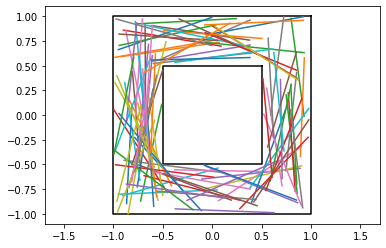

In [ ]:
env_square1 = [Point(0, 0).buffer(1.0, cap_style=3)]
env_square2 = [Point(0, 0).buffer(0.5, cap_style=3)]

def onehundred_freeLines(region_x, region_y):
  accepted_lines = []
  while True:
      points = get_random_line(region_x, region_y)
      
      if not does_line_collide(points, env_center_square):
        accepted_lines.append(points)
      if len(accepted_lines) > 100:
        break
  plot_env(env_square1)
  plot_env(env_center_square)
  for line in accepted_lines[:100]:
      l = np.array(line)
      plt.plot(l[:, 0], l[:, 1])
      if does_line_collide(line, env_center_square):
          plt.plot(l[:, 0], l[:, 1], 'r')

onehundred_freeLines([-1, 1], [-1, 1])

In [ ]:
def probabilies_of_line_intersect(region_x, region_y):
  count = 0
  for ii in range(50000):
      points = get_random_line(region_x, region_y)
      if not does_line_collide(points, env_center_square):
          count += 1
  print("The number of not intersect: ", count/50000)


probabilies_of_line_intersect([-1, 1], [-1, 1])

The number of not intersect:  0.2322


## P2.3: Probabilistic Road Maps [8 points]

Now that you have some idea of how to randomly sample points within an environment, let's try to use them to navigate! In this question, you will be building a simple implementation of a Probabilistic Road Map (PRM). The skeleton of how building and planning with a PRM works is as follows:

1. Generate random points (`num_points` of them) throughout the environment. Those points are the nodes in your graph.
2. For each point, find its neighbors (other points within a certain distance `max_edge_length`) and add edges to the graph.
3. Plan through the graph. In the Results/Plotting code below, I have provided you with a scipy function that computes the plan (and plots it) using the `edge_length_matrix` that your code should compute.

In this question, we will represent our graph as a list of points (`points`) and a matrix that stores the edge length (`edge_length_matrix`), where entries of value `0` indicate that no edge exists between the points.

**TASK** Complete the PRM implementation by resolving the `NotImplementedError` below.

**PLOT** Build the PRM graph for `num_iterations = 200` and plot the graph and its solution (using the plotting code I have provided you with below). Include this plot in your writeup.

**RESULTS+PLOT** Write a function that computes the length of the path between the start and the goal, as computed by the PRM. Compute the path length in the environment I have provided as a function of num_iterations (from 100 to 2500 in increments of 100 points). Plot path length vs num_iterations and include that plot in your writeup. [Note(1): be sure to fix your random seed between runs! The path length should monotonically decrease.] [Note(2): Running the code below is much faster without plotting the entire PRM. Feel free to disable any and all plotting code to compute these values.] If no feasible plan exists, feel free to use a cost of 0.

**QUESTION** (2-3 sentences) In your results, you should notice a distinct "drop" at one or two places in the curve of path length versus num_iterations. Why do these drops occur? Feel free to include pictures if you feel they can help you answer the question.


In [ ]:
# Starter code: Build the PRM graph

def plot_env(start, goal, obstacles):
    for poly in obstacles:
        plt.plot(*poly.exterior.xy, 'k')
    
    plt.plot(start[0], start[1], 'b.')
    plt.plot(goal[0], goal[1], 'g*')

    plt.gca().axis('equal')


env_multi = [
    Point(0, -0.5).buffer(1.5, cap_style=3),
    Point(3, 0).buffer(2.0, cap_style=3),
    Point(2, 5).buffer(2.5, cap_style=3),
]


def build_prm_graph(start, goal, region_x, region_y, obstacles, max_distance, num_sampled_points):
    """
    returns: points, edge_length_matrix
    """
    # Initialize the points list and append 
    points = []
    points.append(start)
    points.append(goal)

    for _ in range(num_sampled_points):
        # Randomly generate points and add them to points
        px = random.uniform(region_x[0], region_x[1])
        py = random.uniform(region_y[0], region_y[1])
        points.append([px, py])
        # raise NotImplementedError()

    # Initialize the "edge length graph"
    edge_length_matrix = np.zeros((len(points), len(points)))

    # Loop through all points, get their neighbors and test for collision with the environment.
    # You can use a double for-loop for this question (outer loop for the points and an 
    # inner loop to get the neighbors), though there are *way* faster ways to do this.
    for ii, point_a in enumerate(points):
        for jj, point_b in enumerate(points[ii+1:]):
            # reject (continue) if the points are within the max distance
            dis = np.sqrt(np.square(point_a[0]-point_b[0]) + np.square(point_a[1]-point_b[1]))
            if dis > max_distance:
              continue
            # raise NotImplementedError()
        
            # Collision check: if the line between the points collides with the geometry, continue.
            line = [point_a, point_b]
            if does_line_collide(line, obstacles):
              continue

            # raise NotImplementedError()
        
            # Update the edge_length_matrix
            edge_length_matrix[ii, jj+ii+1] = dis
            edge_length_matrix[jj+ii+1, ii] = dis
        
    return points, edge_length_matrix

19.93624605555833
19.936246055558325


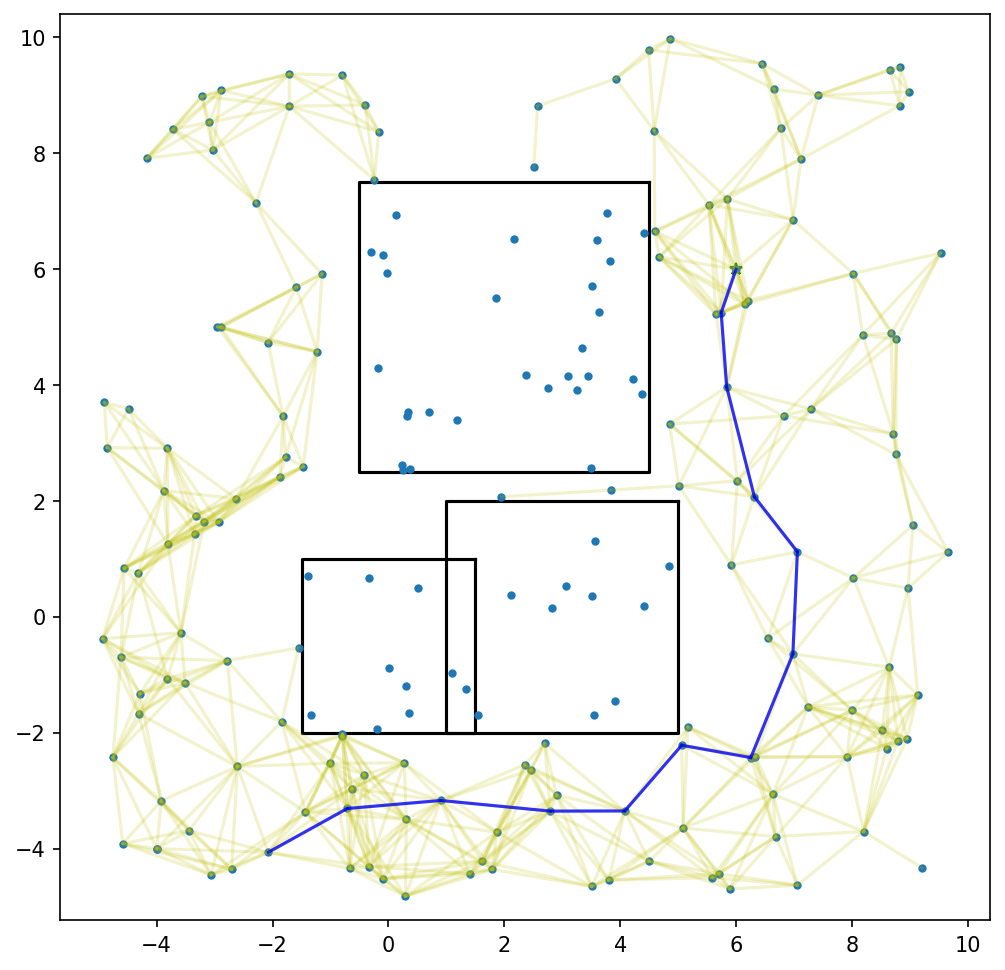

In [ ]:
# Results & Plotting Code: PRM
random.seed(695)

# Parameters:
num_sampled_points = 200
max_distance = 2.0
start = [-4, -4]
goal = [6, 6]
region_x = [-5, 10]
region_y = [-5, 10]

plt.figure(figsize=(8, 8), dpi=150)

# Plot the environment
plot_env(start, goal, env_multi)

points, edge_lengths = build_prm_graph(start, goal, region_x, region_y,
                                       env_multi, max_distance, num_sampled_points)

# Plot the points
np_points = np.array(points)
plt.plot(np_points[:, 0], np_points[:, 1], '.')

# Plot the edges between the points
for ii, point_a in enumerate(points):
    for jj, point_b in enumerate(points[ii+1:]):
        if edge_lengths[ii, jj+ii+1] > 0:
            plt.plot([point_a[0], point_b[0]],
                     [point_a[1], point_b[1]],
                     'y', alpha=0.2)

#  Plan and visualize the plan
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

dist_matrix, predecessors = shortest_path(csgraph=edge_lengths, method='D', directed=False, indices=0, return_predecessors=True)
print(dist_matrix[1])
# print(predecessors)

prev_ind = 1
counter = 0
distance = 0
did_reach_goal = True
while counter < num_sampled_points:
    point_ind = predecessors[prev_ind]
    if point_ind == 0:
        did_reach_goal = True
        point_a = points[prev_ind]
        point_b = points[point_ind]
        distance += edge_lengths[prev_ind, point_ind]
        break
    if point_ind < 0:
        did_reach_goal = False
        break
    point_a = points[prev_ind]
    point_b = points[point_ind]
    distance += edge_lengths[prev_ind, point_ind]
    plt.plot([point_a[0], point_b[0]],
             [point_a[1], point_b[1]],
             'b', alpha=0.8)
    
    prev_ind = point_ind
    
    counter += 1
print(distance)

if not did_reach_goal:
    raise ValueError("Did not reach goal")

In [ ]:
# Results & Plotting Code: PRM
random.seed(695)
def calculate_path_length(sample_number, number_of_step):
  sample_n = []
  lengths = []
  for i in range(number_of_step):    
    points, edge_lengths = build_prm_graph(start, goal, region_x, region_y,
                                       env_multi, max_distance, sample_number)
    dist_matrix, predecessors = shortest_path(csgraph=edge_lengths, method='D', directed=False, indices=0, return_predecessors=True)

    prev_ind = 1
    counter = 0
    distance = 0
    did_reach_goal = True
    while counter < sample_number:
        point_ind = predecessors[prev_ind]
        if point_ind == 0:
            did_reach_goal = True
            point_a = points[prev_ind]
            point_b = points[point_ind]
            distance += edge_lengths[prev_ind, point_ind]
            sample_n.append(sample_number)
            lengths.append(distance)
            plt.plot([point_a[0], point_b[0]],
             [point_a[1], point_b[1]],
             'b', alpha=0.8)
            break
        if point_ind < 0:
            did_reach_goal = False
            break
        point_a = points[prev_ind]
        point_b = points[point_ind]
        distance += edge_lengths[prev_ind, point_ind]
        prev_ind = point_ind 
        counter += 1
        plt.plot([point_a[0], point_b[0]],
          [point_a[1], point_b[1]],
          'b', alpha=0.8)
    
    if not did_reach_goal:
        print("Did not reach goal")
    else:
        print("With the sample number of {} the distance is: {}".format(sample_number,distance))
    sample_number += 100
  return lengths, sample_n

Did not reach goal
With the sample number of 200 the distance is: 17.9184001702575
With the sample number of 300 the distance is: 18.729670726554946
With the sample number of 400 the distance is: 16.62935361728388
With the sample number of 500 the distance is: 17.794281251412684


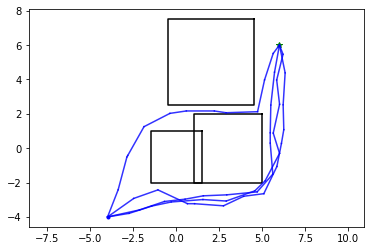

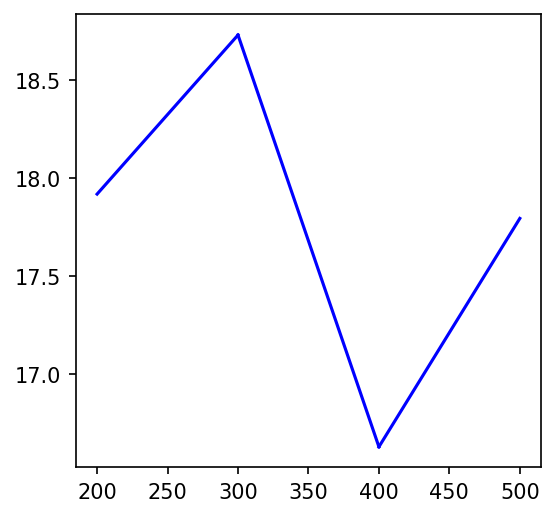

In [ ]:
initial_sample = 100
step = 5
# plt.figure(figsize=(4, 4), dpi=150)
plot_env(start, goal, env_multi)
path_length, sample_list = calculate_path_length(initial_sample, step)
# print(path_length)
# print(sample_list)
plt.figure(figsize=(4, 4), dpi=150)
for ii in range(len(path_length)):
  if ii < len(path_length)-1:
    plt.plot([sample_list[ii],sample_list[ii+1]],[path_length[ii],path_length[ii+1]],
                      'b')

## P2.4: RRT and RRT*

### P2.4.1 Building a (random) chain [4 points]

In this question, you will familiarize yourself with some of the basics of using random sampling to incrementally build a path (as opposed to PRM, an "offline" approach). 
The code below relies on a `Link` class, that is defined mostly by a single point (the end of the link) and an upstream link, which defines the earlier point to which that link is connected. These links can be used to create a Tree (a data structure with a single 'root' Link and 'branches' coming off of that). 
In the "random chain" code I provide you with below, the last link in the chain is randomly added to.

**QUESTION** (2-3 sentences) What does the function `steer_towards_point` do? How would this function need to change if the vehicle had dynamics (and could not simply move in the direction of the new point)?

**PLOTS** Run the "random chain" code below and observe the results. This should generate two plots (in a single figure). Include them in your writeup.

**QUESTION** (4-8 sentences) Describe the results and discuss the algorithmic properties of the algorithm. Is this planner *complete* (will it always eventually find a path to the goal)? Is it asymptotically optimal (will that path approach the shortest path in the limit of infinite samples)?


In [ ]:
import numpy as np
import random
from shapely.geometry import LineString

class Link(object):
    def __init__(self, point, upstream=None):
        self.point = point
        self.upstream = upstream
        if upstream is not None:
            self.geom_line = LineString([point, upstream.point])
            self.local_cost = upstream.get_distance(point)
        else:
            self.geom_line = None
            self.local_cost = 0
    
    @property
    def cost(self):
        if self.upstream is not None:
            return self.upstream.cost + self.local_cost
        else:
            return 0
        
    def get_distance(self, point):
        return np.linalg.norm(np.array(self.point) - np.array(point))
    
    def does_collide(self, obstacles):
        if self.upstream is None:
            return False
        return any(self.geom_line.intersects(obstacle)
                   for obstacle in obstacles)
    
    def __str__(self):
        return str(self.geom_line)
    
    def __hash__(self):
        return hash(id(self))
    
    def plot(self, fmt='b', alpha=1):
        if self.upstream is not None:
            plt.plot([self.point[0], self.upstream.point[0]],
                     [self.point[1], self.upstream.point[1]], fmt,
                    alpha=alpha)
            
def plot_env(start, goal, obstacles):
    for poly in obstacles:
        plt.plot(*poly.exterior.xy, 'k')
    
    plt.plot(start[0], start[1], 'b.')
    plt.plot(goal[0], goal[1], 'g*')

    plt.gca().axis('equal')
    
def get_goal_path_length(goal, all_links, step_size):
    closest_link_to_goal = min(all_links, key=lambda l: l.get_distance(goal))
    if closest_link_to_goal.get_distance(goal) > step_size:
        return None
    goal_path = Link(goal, upstream=closest_link_to_goal)
    return goal_path.cost

def plot_environment_and_links(start, goal, obstacles, all_links, do_plot_goal_path=True):
        
    for link in all_links:
        link.plot(fmt='y', alpha=0.5)

    closest_link_to_goal = min(all_links, key=lambda l: l.get_distance(goal))
    goal_path = Link(goal, upstream=closest_link_to_goal)
    plt.title(f"Cost of path: {goal_path.cost}")
    if do_plot_goal_path:
        while goal_path is not None:
            goal_path.plot(fmt='b')
            goal_path = goal_path.upstream

    plot_env(start, goal, obstacles)

In [ ]:
# Code: Random Chain

# Environment Definition
env_multi = [
    Point(0, -0.5).buffer(1.5, cap_style=3),
    Point(3, 0).buffer(2.0, cap_style=3),
    Point(2, 5).buffer(2.5, cap_style=3),
]

start = [-4, -4]
goal = [6, 6]
step_size=2.0

region_x = [-5, 10]
region_y = [-5, 10]

def steer_towards_point(link, new_point, step_size):
    d = link.get_distance(new_point)
    dx = (new_point[0] - link.point[0])
    dy = (new_point[1] - link.point[1])
    if d > step_size:
        dx *= step_size / d
        dy *= step_size / d
    new_point = [link.point[0] + dx, link.point[1] + dy]

    return Link(new_point, upstream=link), new_point

# Random Chain Code
def generate_random_link_chain(start, goal, obstacles, region_x, region_y, 
                               num_iterations, step_size, seed=695):
    random.seed(seed)
    links = [Link(start)]
    for _ in range(num_iterations):
        # Generate a random point
        px = random.uniform(region_x[0], region_x[1])
        py = random.uniform(region_y[0], region_y[1])
        point = [px, py]
    
        # Get the closest link
        latest_link = links[-1]

        # Steer towards it
        new_link, new_point = steer_towards_point(latest_link, point, step_size)

        # If it collides, return
        if new_link.does_collide(obstacles):
            continue

        # Add to chain if it does not collide
        links.append(new_link)

    return links

Random Link Chain
Path Length (Iterations: 1000): 436.2004593753845


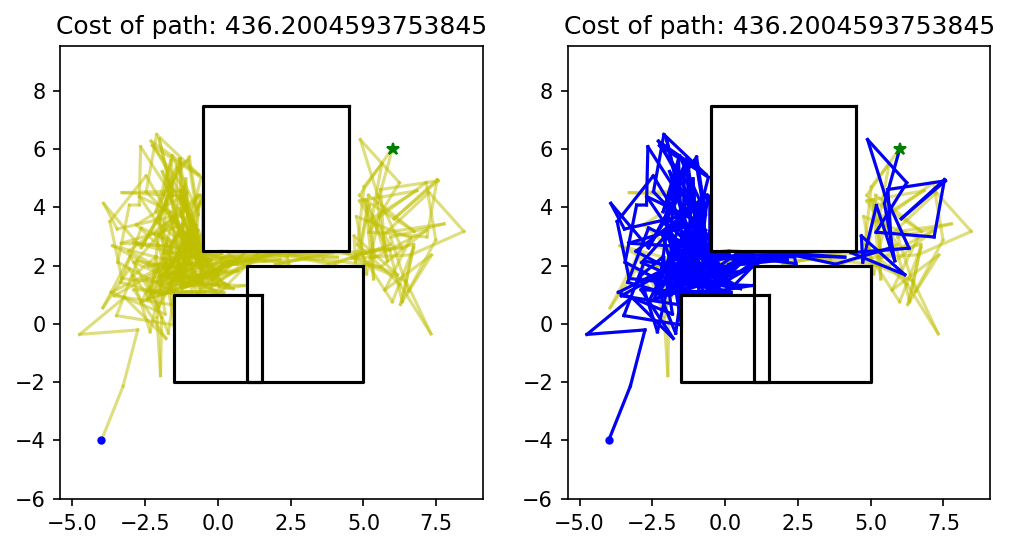

In [ ]:
# Plotting Code for the Random Link Chain
print("Random Link Chain")
num_iterations = 1000
links = generate_random_link_chain(start, goal, env_multi, region_x, region_y, 
                                   num_iterations, step_size)

print(f"Path Length (Iterations: {num_iterations}): {get_goal_path_length(goal, links, step_size)}")
plt.figure(figsize=(8, 4), dpi=150)
plt.subplot(121)
plot_environment_and_links(start, goal, env_multi, links, do_plot_goal_path=False)
plt.subplot(122)
plot_environment_and_links(start, goal, env_multi, links, do_plot_goal_path=True)

### P2.4.2: RRT [8 points]

**TASK** Implement RRT! You may use the `generate_random_link_chain` as starter code. There is really only one place the code needs to change: instead of `latest_link`, you should select the link based on distance to the `point`.

**PLOTS** Run the RRT plotting code below, generating 4 plots in 1 figure that show the performance as a function of number of iterations. Include these plots in your writeup.

**QUESTION** (4-8 sentences) Describe the results and discuss the algorithmic properties of the algorithm. Is this planner *complete* (will it always eventually find a path to the goal)? Is it asymptotically optimal (will that path approach the shortest path in the limit of infinite samples)? How do your theoretical claims match up with the results (from your plots above)?

**CODE** Include a code block containing your finished RRT implementation in your writeup.

In [ ]:
# Random Chain Code
def RRT(start, goal, obstacles, region_x, region_y, 
                               num_iterations, step_size, seed=695):
    random.seed(seed)
    links = [Link(start)]
    for _ in range(num_iterations):
        # Generate a random point
        px = random.uniform(region_x[0], region_x[1])
        py = random.uniform(region_y[0], region_y[1])
        point = [px, py]
        # Get the closest link
        min_dist = 2000.0
        nearest_link = links[-1]
        for link in links:
          dist1 = link.get_distance(point)
          if dist1 < min_dist:
            min_dist = dist1
            nearest_link = link
        # Steer towards it
        new_link, new_point = \
              steer_towards_point(nearest_link, point, step_size)
        if new_link.does_collide(obstacles):
            continue
        # Add to chain if it does not collide
        links.append(new_link)

    return links

RRT
Path Length (Iterations: 100): 26.31012255828789
Path Length (Iterations: 500): 27.239939840704494
Path Length (Iterations: 2000): 27.470793394815708
Path Length (Iterations: 4000): 27.62794988794019


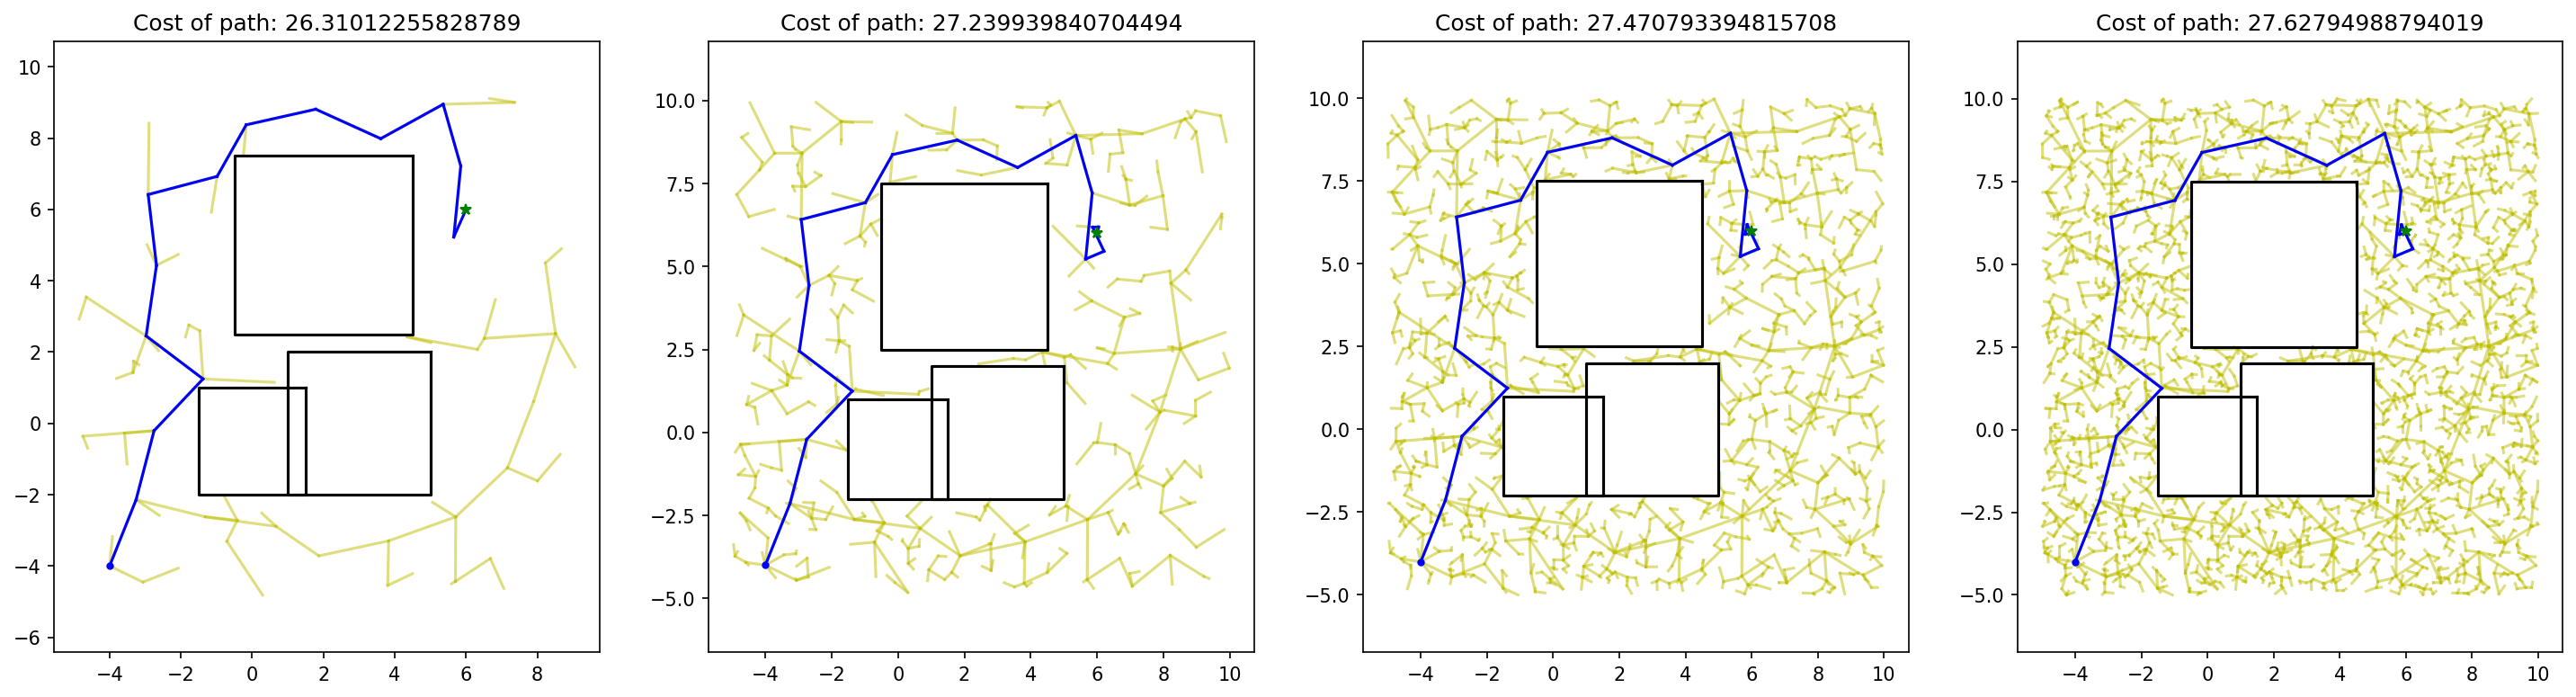

In [ ]:
# RRT Plotting code
print("RRT")

def run_for_iterations(num_iterations):
    links = RRT(start, goal, env_multi, region_x, region_y, 
                num_iterations, step_size)
    print(f"Path Length (Iterations: {num_iterations}): {get_goal_path_length(goal, links, step_size)}")
    plot_environment_and_links(start, goal, env_multi, links, do_plot_goal_path=True)

plt.figure(figsize=(24, 6), dpi=150)
iterations = [100, 500, 2000, 4000]
for ii, num_iterations in enumerate(iterations):
    plt.subplot(1, len(iterations), ii + 1)
    run_for_iterations(num_iterations)

### P2.4.2: RRT* [8 points]

**TASK** Implement RRT* (`RRTstar`)! Look through the lecture notes for implementation details. Every time you add a new point, you will need to loop through all links with points within `step_size` of the new point (each an `other_link`) and look for potential improvements: if you can extend your current link to the point of the `other_link` and that new link is shorter than the current path length of the other link, replace the upstream of that link to be the newer point you just added. [The lecture materials say this in more detail, though you will still need to think to get this right! One thing to realize here is that because the RRT* data forms a tree, you should never need to remove any points; you only need to change the upstream (and the costs associated with the link you're modifying).]

**PLOTS** Run the RRTstar plotting code below, generating 4 plots in 1 figure that show the performance as a function of number of iterations. Include these plots in your writeup.

**QUESTION** (4-8 sentences) Describe the results and discuss the algorithmic properties of the algorithm. Is this planner *complete* (will it always eventually find a path to the goal)? Is it asymptotically optimal (will that path approach the shortest path in the limit of infinite samples)? How do your theoretical claims match up with the results (from your plots above)?

**CODE** Include a code block containing your finished RRT* implementation in your writeup.

In [ ]:
# RRT* Plotting code
def RRTstar(start, goal, obstacles, region_x, region_y, 
                               num_iterations, step_size, seed=695):
    random.seed(seed)
    links = [Link(start)]
    for _ in range(num_iterations):
        # Generate a random point
        px = random.uniform(region_x[0], region_x[1])
        py = random.uniform(region_y[0], region_y[1])
        point = [px, py]
    
        # Get the closest link
        min_dist = 2000.0
        nearest_link = links[-1]
        for link in links:
          dist1 = link.get_distance(point)
          if dist1 < min_dist:
            min_dist = dist1
            nearest_link = link

        # Steer towards it
        new_link, new_point = steer_towards_point(nearest_link, point, step_size)

        # If it collides, return
        if new_link.does_collide(obstacles):
            continue

        # Add to chain if it does not collide
        links.append(new_link)
        # find the near points set
        points_near = []
        for link in links:
          dist1 = link.get_distance(new_point)
          # new_point
          if dist1 < step_size:
            points_near.append(link)
        
        min_cost = new_link.cost
        min_point = nearest_link
        # Adjust the new point's parent
        for point_near in points_near:
            line2 = LineString([new_point, point_near.point])
            cost = point_near.get_distance(new_point)
            # check collision
            if any(line2.intersects(obstacle) for obstacle in obstacles):
              continue
            else:   # Adjust the new point's parent
              if min_cost > point_near.cost + cost:
                min_point = point_near
                min_cost = point_near.cost + cost
        new_link.upstream = min_point
        new_link.geom_line = LineString([new_point, min_point.point])
        new_link.local_cost = min_point.get_distance(new_point)
        # Rewire the tree
        for point_near in points_near:
            line3 = LineString([new_point, point_near.point])
            cost = point_near.get_distance(new_point)
            # check collision
            if any(line3.intersects(obstacle) for obstacle in obstacles):
              continue
            else:   # Adjust the paths
              if point_near.cost > new_link.cost + cost:
                point_near.upstream = new_link
                point_near.geom_line = line3
                point_near.local_cost = cost

    return links

RRTstar
Path Length (Iterations: 100): 24.205382270208585
Path Length (Iterations: 500): 17.99492208913441
Path Length (Iterations: 2000): 15.848699772193154
Path Length (Iterations: 4000): 15.781310565027463


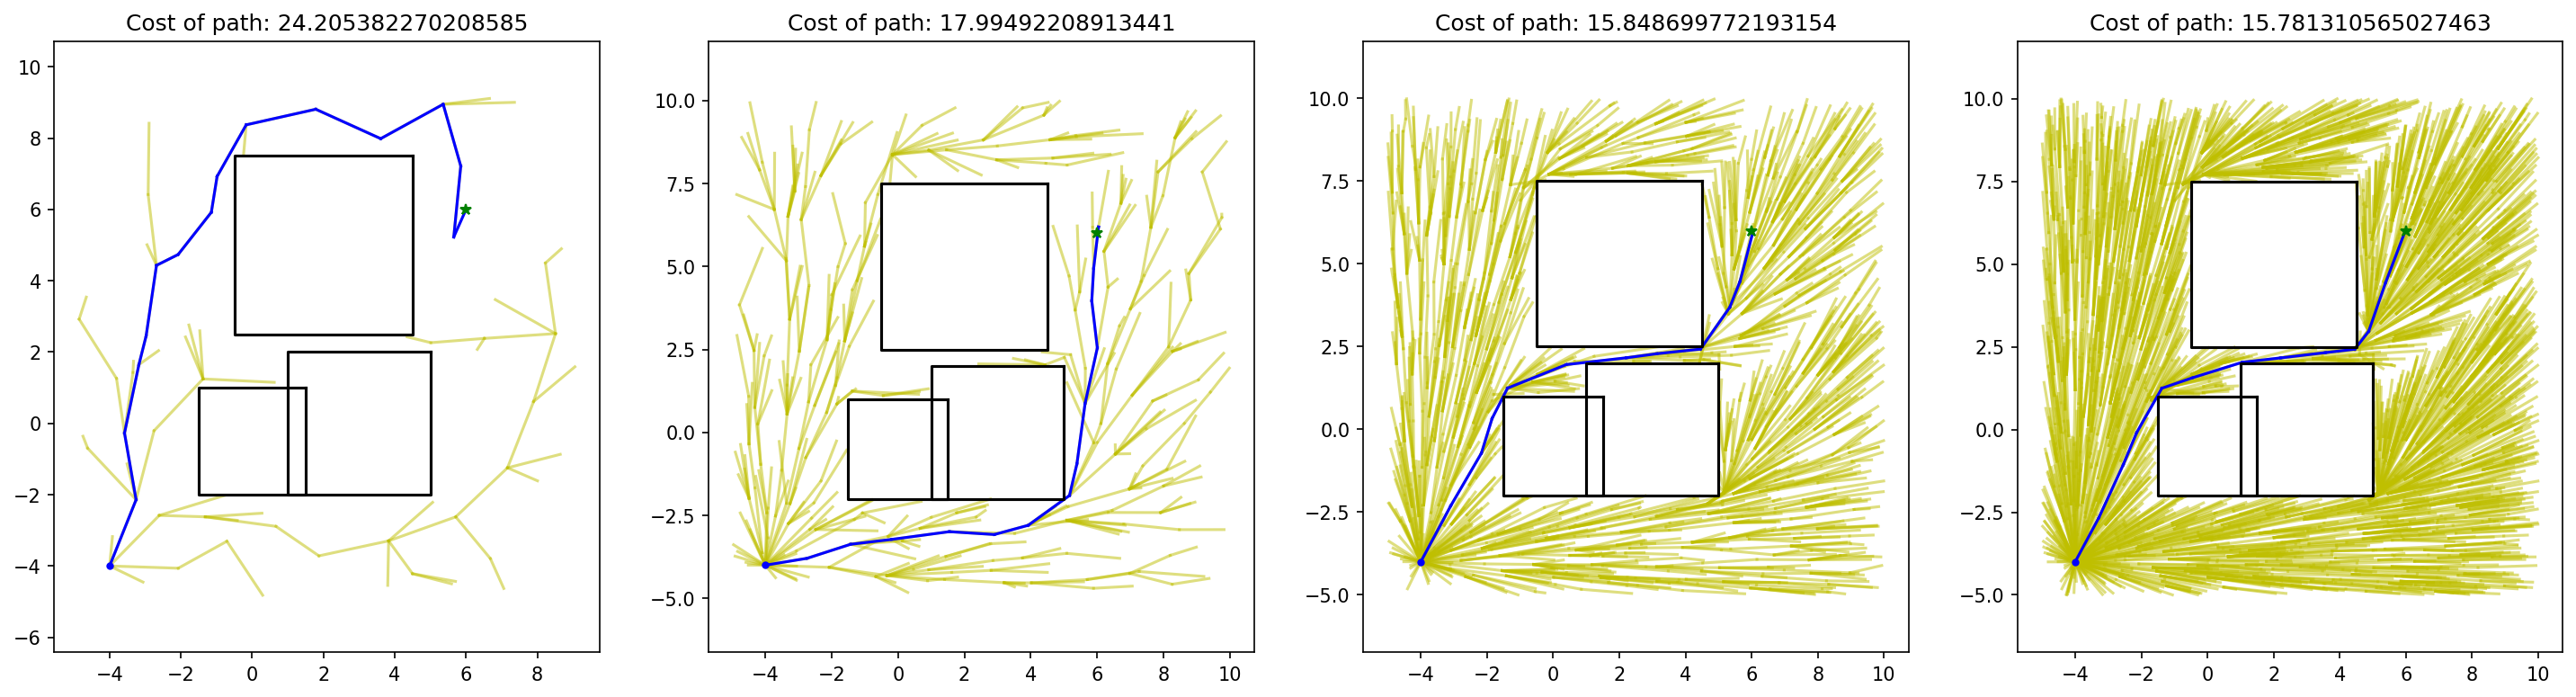

In [ ]:
# RRT* Plotting code
print("RRTstar")

def run_for_iterations(num_iterations):
    links = RRTstar(start, goal, env_multi, region_x, region_y, 
                    num_iterations, step_size)
    print(f"Path Length (Iterations: {num_iterations}): {get_goal_path_length(goal, links, step_size)}")
    plot_environment_and_links(start, goal, env_multi, links, do_plot_goal_path=True)

plt.figure(figsize=(24, 6), dpi=150)
iterations = [100, 500, 2000, 4000]
for ii, num_iterations in enumerate(iterations):
    plt.subplot(1, len(iterations), ii + 1)
    run_for_iterations(num_iterations)
